<a href="https://colab.research.google.com/github/mudesir/DS-Unit-2-Linear-Models/blob/master/Mudesir_LS_DS17_212_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 2*

---

# Regression 2

## Assignment

You'll continue to **predict how much it costs to rent an apartment in NYC,** using the dataset from renthop.com.

- [ ] Do train/test split. Use data from April & May 2016 to train. Use data from June 2016 to test.
- [ ] Engineer at least two new features. (See below for explanation & ideas.)
- [ ] Fit a linear regression model with at least two features.
- [ ] Get the model's coefficients and intercept.
- [ ] Get regression metrics RMSE, MAE, and $R^2$, for both the train and test data.
- [ ] What's the best test MAE you can get? Share your score and features used with your cohort on Slack!
- [ ] As always, commit your notebook to your fork of the GitHub repo.


#### [Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)

> "Some machine learning projects succeed and some fail. What makes the difference? Easily the most important factor is the features used." — Pedro Domingos, ["A Few Useful Things to Know about Machine Learning"](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)

> "Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering." — Andrew Ng, [Machine Learning and AI via Brain simulations](https://forum.stanford.edu/events/2011/2011slides/plenary/2011plenaryNg.pdf) 

> Feature engineering is the process of using domain knowledge of the data to create features that make machine learning algorithms work. 

#### Feature Ideas
- Does the apartment have a description?
- How long is the description?
- How many total perks does each apartment have?
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths)
- Ratio of beds to baths
- What's the neighborhood, based on address or latitude & longitude?

## Stretch Goals
- [ ] If you want more math, skim [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf),  Chapter 3.1, Simple Linear Regression, & Chapter 3.2, Multiple Linear Regression
- [ ] If you want more introduction, watch [Brandon Foltz, Statistics 101: Simple Linear Regression](https://www.youtube.com/watch?v=ZkjP5RJLQF4)
(20 minutes, over 1 million views)
- [ ] Add your own stretch goal(s) !

In [77]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [78]:
import numpy as np
import pandas as pd

# Read New York City apartment rental listing data
df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

In [3]:
print(df.shape)
df.head()

(48817, 34)


,bathrooms,bedrooms,created,description,display_address,latitude,longitude,price,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,3000,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,5465,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,2850,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,3275,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,3350,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48817 entries, 0 to 49351
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48817 non-null  float64
 1   bedrooms              48817 non-null  int64  
 2   created               48817 non-null  object 
 3   description           47392 non-null  object 
 4   display_address       48684 non-null  object 
 5   latitude              48817 non-null  float64
 6   longitude             48817 non-null  float64
 7   price                 48817 non-null  int64  
 8   street_address        48807 non-null  object 
 9   interest_level        48817 non-null  object 
 10  elevator              48817 non-null  int64  
 11  cats_allowed          48817 non-null  int64  
 12  hardwood_floors       48817 non-null  int64  
 13  dogs_allowed          48817 non-null  int64  
 14  doorman               48817 non-null  int64  
 15  dishwasher         

In [9]:
df['created']

0        2016-06-24 07:54:24
1        2016-06-12 12:19:27
2        2016-04-17 03:26:41
3        2016-04-18 02:22:02
4        2016-04-28 01:32:41
                ...         
49347    2016-06-02 05:41:05
49348    2016-04-04 18:22:34
49349    2016-04-16 02:13:40
49350    2016-04-08 02:13:33
49351    2016-04-12 02:48:07
Name: created, Length: 48817, dtype: object

In [13]:
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S')

In [14]:
# choose the target and the feature variabl, that is y and X
y = df['price']
y.shape


(48817,)

In [15]:
X = df.drop('price', axis=1)
df.shape

(48817, 34)

In [18]:
# Split the dataframe into train and test according to the given condition 
X_train = X[((X['created']>='2016-04-01 00:00:00') & (X['created']<'2016-06-01 00:00:00'))]
X_train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:

X_test = X[((X['created']>='2016-06-01 00:00:00') & (X['created']<'2016-07-01 00:00:00'))]
X_test.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1.0,1,2016-06-03 03:21:22,Check out this one bedroom apartment in a grea...,W. 173rd Street,40.8448,-73.9396,644 W. 173rd Street,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.0,1,2016-06-01 03:11:01,Spacious 1-Bedroom to fit King-sized bed comfo...,East 56th St..,40.7584,-73.9648,315 East 56th St..,low,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2.0,4,2016-06-07 04:39:56,SPRAWLING 2 BEDROOM FOUND! ENJOY THE LUXURY OF...,W 18 St.,40.7391,-73.9936,30 W 18 St.,medium,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0


In [25]:
# finding y_train and y_test
y_test = y[y.index.isin(X_test.index)]
print('y-test', y_test.shape)
y_train = y[y.index.isin(X_train.index)]
print('y-train', y_train.shape)


y-test (16973,)
y-train (31844,)


In [26]:
# Begin with basline 0 feature
guess = y_train.mean()
guess

3575.604007034292

In [27]:
# Train Error
from sklearn.metrics import mean_absolute_error

y_pred = [y_train.mean()] * len(y_train)

In [29]:
# calculate the mean absolute error
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error (April-May, 2016 rent appartment price): {mae:.2f} dollars')

Train Error (April-May, 2016 rent appartment price): 1201.88 dollars


In [30]:
# Test Error
y_pred = [y_train.mean()] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Train Error (April-May, 2016 rent appartment price): {mae:.2f} dollars')

Train Error (April-May, 2016 rent appartment price): 1197.71 dollars


In [89]:
import pandas as pd
import plotly.express as px

fig = px.scatter(X_train, x='bedrooms', y=y_train, title='NYC Apartment Rent, April-June, 2016') 
fig.show()   


In [45]:
# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

In [46]:
# 2. Instantiate this class
model = LinearRegression()

In [ ]:
# split the X and y already done above

In [47]:
# 4. Fit the model
model.fit(X_train[['bedrooms']], y_train)
y_pred = model.predict(X_train[['bedrooms']])
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} dollars')

Train Error: 969.88 dollars


In [48]:
# 5. Apply the model to new data
y_pred = model.predict(X_test[['bedrooms']])
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} dollars')

Test Error: 988.73 dollars


Compare to the baslines or 0 feature to 1 feature, the mean absolute error of diference about 250 dollars

In [79]:
# predicting using more than 1 features
y1 = df['price']
X1 = df[['bedrooms', 'bathrooms']]

In [80]:
# Split the dataframe into train and test according to the given condition 
X1_train = X[((X['created']>='2016-04-01 00:00:00') & (X['created']<'2016-06-01 00:00:00'))]
X1_train.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
2,1.0,1,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,40.7388,-74.0018,241 W 13 Street,high,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,1,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,40.7539,-73.9677,333 East 49th Street,low,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,4,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,40.8241,-73.9493,500 West 143rd Street,low,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2.0,4,2016-04-19 04:24:47,,West 18th Street,40.7429,-74.0028,350 West 18th Street,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1.0,2,2016-04-27 03:19:56,Stunning unit with a great location and lots o...,West 107th Street,40.8012,-73.9660,210 West 107th Street,low,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
X1_test = X[((X['created']>='2016-06-01 00:00:00') & (X['created']<'2016-07-01 00:00:00'))]
X1_test.head()

,bathrooms,bedrooms,created,description,display_address,latitude,longitude,street_address,interest_level,elevator,cats_allowed,hardwood_floors,dogs_allowed,doorman,dishwasher,no_fee,laundry_in_building,fitness_center,pre-war,laundry_in_unit,roof_deck,outdoor_space,dining_room,high_speed_internet,balcony,swimming_pool,new_construction,terrace,exclusive,loft,garden_patio,wheelchair_access,common_outdoor_space
0,1.5,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,40.7145,-73.9425,792 Metropolitan Avenue,medium,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,2,2016-06-12 12:19:27,,Columbus Avenue,40.7947,-73.9667,808 Columbus Avenue,low,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,1.0,1,2016-06-03 03:21:22,Check out this one bedroom apartment in a grea...,W. 173rd Street,40.8448,-73.9396,644 W. 173rd Street,low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1.0,1,2016-06-01 03:11:01,Spacious 1-Bedroom to fit King-sized bed comfo...,East 56th St..,40.7584,-73.9648,315 East 56th St..,low,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,2.0,4,2016-06-07 04:39:56,SPRAWLING 2 BEDROOM FOUND! ENJOY THE LUXURY OF...,W 18 St.,40.7391,-73.9936,30 W 18 St.,medium,1,1,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0


In [84]:
X2_train = X1_train[['bedrooms', 'bathrooms']]
X2_train.head()

,bedrooms,bathrooms
2,1,1.0
3,1,1.0
4,4,1.0
5,4,2.0
6,2,1.0


In [85]:
X2_test = X1_test[['bedrooms', 'bathrooms']]
X2_test.head()

,bedrooms,bathrooms
0,3,1.5
1,2,1.0
11,1,1.0
14,1,1.0
24,4,2.0


In [90]:
# finding y_train and y_test
y1_test = y1[y1.index.isin(X2_test.index)]
print('y1-test', y1_test.shape)
y1_train = y1[y1.index.isin(X2_train.index)]
print('y1-train', y1_train.shape)

y1-test (16973,)
y1-train (31844,)


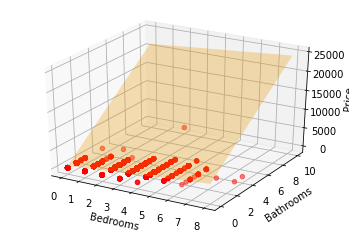

In [96]:
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

x = X_train
Y = y_train
df2 = pd.DataFrame(X, columns=['bedrooms','bathrooms'])
df2['price'] = pd.Series(Y)

model2 = smf.ols(formula='price ~bedrooms+bathrooms', data=df2)
results_formula = model2.fit()
results_formula.params
x_surf, y_surf = np.meshgrid(np.linspace(df2.bedrooms.min(), df2.bedrooms.max(), 100),
                             np.linspace(df2.bathrooms.min(), df2.bathrooms.max(), 100))
onlyX = pd.DataFrame({'bedrooms': x_surf.ravel(), 'bathrooms': y_surf.ravel()})
fittedY = results_formula.predict(exog = onlyX)
fittedY = np.array(fittedY)

fig = plt.figure()
ax = fig.add_subplot(111,projection= '3d')
ax.scatter(df2['bedrooms'], df2['bathrooms'], c='red', marker='o', alpha=0.5)
ax.plot_surface(x_surf, y_surf, fittedY.reshape(x_surf.shape), color='orange', alpha=0.3)
ax.set_xlabel('Bedrooms')
ax.set_ylabel('Bathrooms')
ax.set_zlabel('Price')
plt.show()

In [71]:
y1_train.describe()

count    31844.000000
mean      3575.604007
std       1762.136694
min       1375.000000
25%       2500.000000
50%       3150.000000
75%       4095.000000
max      15500.000000
Name: price, dtype: float64

In [86]:
from sklearn import linear_model
model1 = linear_model.LinearRegression()
model1.fit(X2_train, y1_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
y1_pred = model1.predict(X2_train)
mae = mean_absolute_error(y1_train, y1_pred)
print(f'Train Error: {mae:.2f} dollars')

Train Error: 818.53 dollars


In [95]:
y1_pred = model1.predict(X2_test)
mae = mean_absolute_error(y1_test, y1_pred)
print(f'Test Error: {mae:.2f} dollars')

Test Error: 825.90 dollars


Get and interpret coefficients
What’s the equation for the plane of best fit?

$y = \beta_0 + \beta_1x_1 + \beta_2x_2$

In [99]:
model1.intercept_, model1.coef_


(485.71869002322273, array([ 389.3248959 , 2072.61011639]))

In [102]:
beta0 = model1.intercept_.round(2)
beta1, beta2 = model1.coef_.round(2)
print(f'y = {beta0} + {beta1}x1 + {beta2}x2')

y = 485.72 + 389.32x1 + 2072.61x2


In [104]:
# Both of the coefficients are positive What does this mean? that it increase by the coefficient amount for each unit increase
# What does the model predict if different bedrooms and bathrooms
model1.predict([[1,1]])

array([2947.65370231])

In [105]:
# 2 bedrooms and 1 bathroom
model1.predict([[2,1]])

array([3336.97859821])

In [106]:
# 2 bedrooms and 2 bathroom
model1.predict([[2,2]])

array([5409.5887146])